<a href="https://colab.research.google.com/github/dirudiez/TFM_DiegoRudiez/blob/main/MultiLabel_efficientnet_b3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clasificador Multilabel

https://walkwithfastai.com/Multi_Label

## Librerías

Instalamos la última versión de Fastai:

In [1]:
!pip install fastai -Uq
!pip install timm

#Reiniciamos el entorno de ejecución automáticamente
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

{'restart': True, 'status': 'ok'}

In [4]:
!pip install wwf -q

Importamos las librerías necesarias:

In [5]:
from fastai.vision.all import *

#Estas liberías son para las arquitectuas EffiecientNet e Inception
import timm
from wwf.utils import *
from wwf.vision.timm import * 

In [3]:
import pandas as pd

import torch
from torch import nn

from fastcore.meta import use_kwargs_dict

from fastai.callback.fp16 import to_fp16
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_one_cycle

from fastai.data.block import MultiCategoryBlock, DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import RandomSplitter, ColReader

from fastai.metrics import accuracy_multi, BaseLoss

from fastai.vision.augment import aug_transforms
from fastai.vision.data import ImageBlock
from fastai.vision.learner import cnn_learner

from torchvision.models import resnet34

## Dataset

Descargamos el dataset

In [6]:
!wget https://www.dropbox.com/s/o1eaoae59qgdo4i/Training_Set_Pre.zip?dl=0 --no-verbose -O train.zip
!wget https://www.dropbox.com/s/5od5cac9xhxlcwu/Test_Set_Pre.zip?dl=0 --no-verbose -O test.zip
!wget https://www.dropbox.com/s/gjz445xm4oddfus/Evaluation_Set_Pre.zip?dl=0 --no-verbose -O val.zip

2022-06-18 11:16:24 URL:https://ucffca5ba9627d6b8895417f7781.dl.dropboxusercontent.com/cd/0/inline2/BnY2v3gSwFowgP4uCUx4XMYgvdiJxvEwyi4yazLY9zNCsyEtvsVoi3JEa91UksGTQ6DvjcRx44kHihxVTdGuR05z5WZ7pcS74Jy2srtIa2HjR-7fa9693vbEeUOnIrccwiEr0oRGnVrk6J9hQOOxrFO9O5OV3b1KhQPzqLXlOnt6SfvO8B3abFAoLoiIECg6LQS1ykL32-hmpAazsuJf3yXAHqj62lwxUQ_nQeBCC0hjHcw7i1qger5ff0svPG8_8gQs3GtIsqgzeAOb4Us9KPPa7lti1T_nCWYtiGIsAT-zkDpkorM1iBSHop5gLB3rPbnPNp2ynoX8uB4NVRiOxVuHisH0Lk85Cf2XBLd-VJVNFVlPlhhttNldgFdp1vYPB0YvDX2-iCrVp5ui2GA1b5IbKAi6RIgz1cB3CmY68B8D3A/file [138777773/138777773] -> "train.zip" [1]
2022-06-18 11:16:26 URL:https://uc2849e95ec881584b3781628a57.dl.dropboxusercontent.com/cd/0/inline2/BnYFHdTkALEbLZg_nO6qjqGPW0NEwhHnUSnpLe-FVn_UyUhN9Ee4eBOO2dYhaN9YUCBOqPAQVQK6zkfaW8tuO67V_3cY4pi6DFOHjYxyLCPt1RN-xwW9w4J_Qu7iuSgt5N7u5yuS3FimNBNtML1L4KRdjL6YiykNlC9HqhTaXbpZ2GArcvhPWx94DaulndX6qx-Ub0FRdOwcG0qWYM3DSMzdDhj-RsAUZ3c0ql_OeA8hklG3U81Y7RmeE1VCMEcBKg0Ohmcj5FxA48wHVTNIZaEhlRyb7KNYbj0QC9jTqv7uZJCN6qXg8usz5y1x_ij5Vie

In [7]:
# !rm -rvf Training_Set_Pre
!unzip -qq train.zip #-qq no verbose
!unzip -qq test.zip
!unzip -qq val.zip

In [8]:
trainPath = Path('Training_Set_Pre/')
testPath  = Path('Test_Set_Pre/')
valPath  =  Path('Evaluation_Set_Pre/')

In [9]:
df_train = pd.read_csv(str(trainPath) + '/train.csv')
df_test = pd.read_csv(str(testPath) + '/test.csv')
df_val = pd.read_csv(str(valPath) + '/val.csv')

In [10]:
df_train

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1915,1916,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1916,1917,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1917,1918,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1918,1919,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
def crearDataFrame(df, nombreConjunto):
  columnas = list(df.columns)[2:]

  nombres = [] #nombre de las imagenes
  enfermedades = [] #nombres de las enfermedades

  for i in df.index:
    cadena = ''
    nombres.append(nombreConjunto + str(df['ID'][i]))
    if df['Disease_Risk'][i] == 1:
      for x in columnas:
        if(df[x][i]==1):
          cadena += ' ' + x
    else:
      cadena = ' NORMAL'
    enfermedades.append(cadena[1:])
  data = {'nombre_img': nombres,
        'tags': enfermedades
        }
  return pd.DataFrame(data)

In [91]:
df_train_ML = crearDataFrame(df_train, str(trainPath) + '/Training/')
df_test_ML = crearDataFrame(df_test, str(testPath) + '/Test/')
df_val_ML = crearDataFrame(df_val, str(valPath) + '/Validation/')

In [92]:
df_train_ML.head(10)

,nombre_img,tags
0,Training_Set_Pre/Training/1,DR
1,Training_Set_Pre/Training/2,DR
2,Training_Set_Pre/Training/3,DR
3,Training_Set_Pre/Training/4,MH ODC
4,Training_Set_Pre/Training/5,DR LS
5,Training_Set_Pre/Training/6,ARMD MYA
6,Training_Set_Pre/Training/7,ARMD MYA
7,Training_Set_Pre/Training/8,ARMD MYA
8,Training_Set_Pre/Training/9,ERM
9,Training_Set_Pre/Training/10,NORMAL


In [93]:
df_train_ML['is_valid'] = False
df_val_ML['is_valid'] = True

In [94]:
df_train_val = pd.concat([df_train_ML, df_val_ML])

In [95]:
df_train_val

,nombre_img,tags,is_valid
0,Training_Set_Pre/Training/1,DR,False
1,Training_Set_Pre/Training/2,DR,False
2,Training_Set_Pre/Training/3,DR,False
3,Training_Set_Pre/Training/4,MH ODC,False
4,Training_Set_Pre/Training/5,DR LS,False
...,...,...,...
635,Evaluation_Set_Pre/Validation/636,TSLN,True
636,Evaluation_Set_Pre/Validation/637,TSLN,True
637,Evaluation_Set_Pre/Validation/638,NORMAL,True
638,Evaluation_Set_Pre/Validation/639,NORMAL,True


In [96]:
# df_train_val[df_train_val['nombre_img']=='val/640']['is_valid'].values[0]

In [97]:
def conjuntoImg(nombreImg):
  return True if df[df['nombre_img'] == nombreImg[0]]['is_valid'].values[0] else False

In [98]:
df = df_train_val

In [99]:
conjuntoImg(['Training_Set_Pre/Training/503','ODP', True])

False

## Datablock

In [100]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [101]:
db = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, suff='.png'),
                   splitter=FuncSplitter(conjuntoImg),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

In [102]:
dls = db.dataloaders(df.values, bs=32)

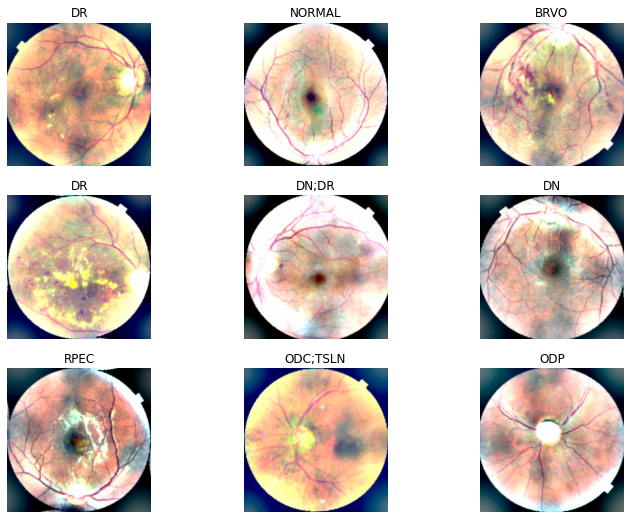

In [103]:
dls.show_batch(max_n=9, figsize=(12,9))

## Entrenar Modelo

In [104]:
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=20),
    SaveModelCallback(fname='modelResnet18')
]

In [105]:
import timm

In [106]:
learn = timm_learner(dls, 'efficientnet_b3', pretrained=True, metrics=[accuracy_multi], cbs=callbacks)

SuggestedLRs(minimum=0.03019951581954956, steep=0.03981071710586548)

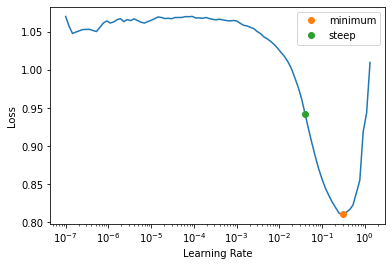

In [107]:
learn.lr_find(suggest_funcs=(minimum, steep))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.565910,0.151801,0.958998,00:27


Better model found at epoch 0 with valid_loss value: 0.15180149674415588.


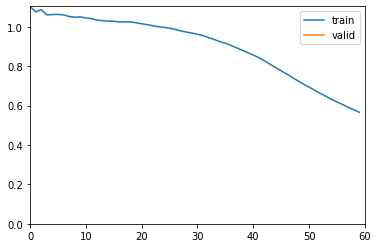

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.140627,0.159296,0.961476,00:35
1,0.127295,0.126740,0.962392,00:33
2,0.117923,0.161961,0.962338,00:34
3,0.113186,0.308868,0.962877,00:34
4,0.104111,0.170592,0.964063,00:33
5,0.101853,0.239546,0.963470,00:33
6,0.096034,0.236675,0.963955,00:33
7,0.092239,0.154728,0.964547,00:33
8,0.088670,0.618129,0.964224,00:33
9,0.085849,0.141150,0.964979,00:33


Better model found at epoch 0 with valid_loss value: 0.1592957079410553.


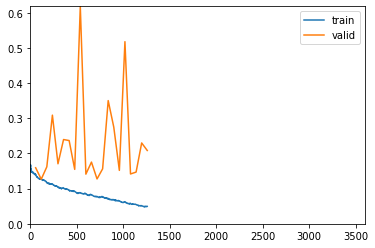

Better model found at epoch 1 with valid_loss value: 0.12673965096473694.
No improvement since epoch 1: early stopping
CPU times: user 8min 2s, sys: 4min 7s, total: 12min 9s
Wall time: 12min 57s


In [48]:
%%time
learn.fine_tune(60,base_lr=1e-2)

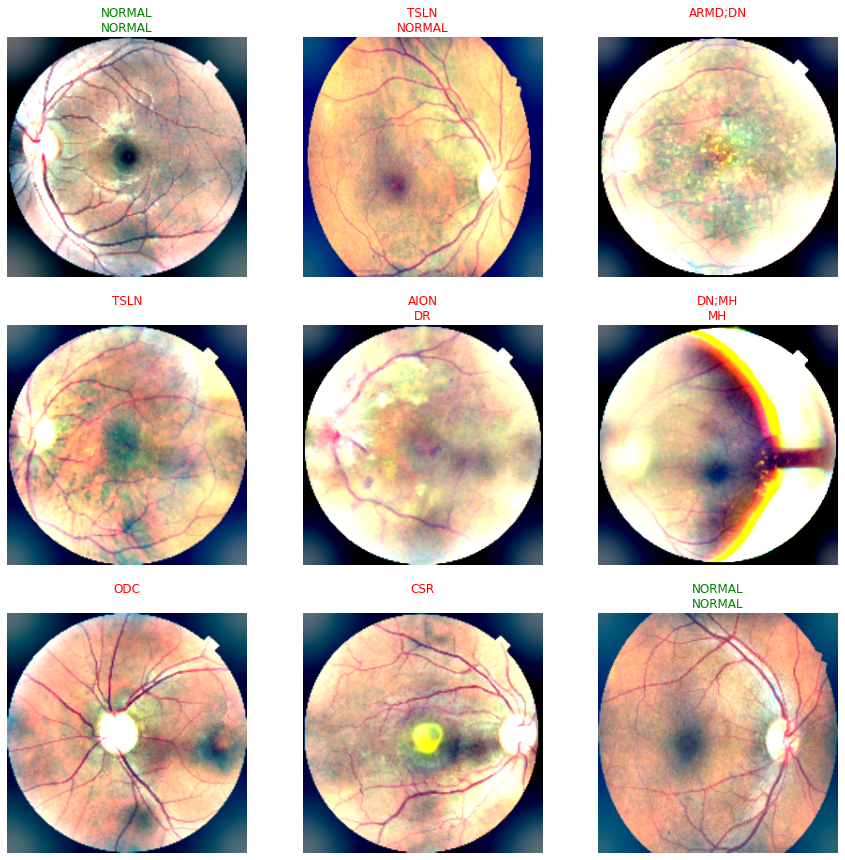

In [49]:
learn.show_results(figsize=(15,15))

## Evaluar el modelo

In [50]:
dbTest = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, suff='.png'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

In [51]:
dlsTest = dbTest.dataloaders(df_test_ML)

In [52]:
learn.dls = dlsTest

In [53]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.9622844457626343.


(#2) [0.11202353239059448,0.9622844457626343]

Exportamos el modelo

In [54]:
learn.to_fp32()
learn.export('MultiLabel_efficientnet_b3.pkl')

## Comprobaciones manuales

In [55]:
learn_inf = load_learner('MultiLabel_efficientnet_b3.pkl')

In [66]:
df_train_ML

,nombre_img,tags,is_valid
0,Training_Set_Pre/Training/1,DR,False
1,Training_Set_Pre/Training/2,DR,False
2,Training_Set_Pre/Training/3,DR,False
3,Training_Set_Pre/Training/4,MH MH ODC,False
4,Training_Set_Pre/Training/5,DR DR LS,False
...,...,...,...
1915,Training_Set_Pre/Training/1916,ODP,False
1916,Training_Set_Pre/Training/1917,DR DR LS,False
1917,Training_Set_Pre/Training/1918,NORMAL,False
1918,Training_Set_Pre/Training/1919,NORMAL,False


In [64]:
df_test_ML

,nombre_img,tags
0,Test_Set_Pre/Test/1,DR DR TSLN
1,Test_Set_Pre/Test/2,DR DR BRVO
2,Test_Set_Pre/Test/3,DR DR ODC
3,Test_Set_Pre/Test/4,AION
4,Test_Set_Pre/Test/5,TV TV AION
...,...,...
635,Test_Set_Pre/Test/636,MYA
636,Test_Set_Pre/Test/637,MYA
637,Test_Set_Pre/Test/638,BRVO
638,Test_Set_Pre/Test/639,RP


In [56]:
df_test[df_test['Disease_Risk']==0]
# df_test.iloc[0:20,:]

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
244,245,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
271,272,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
272,273,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,276,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
276,277,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
622,623,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
625,626,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
626,627,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
627,628,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [57]:
learn_inf.predict('Test_Set_Pre/Test/272.png')[0]

(#1) ['NORMAL']

In [58]:
learn_inf.predict('Test_Set_Pre/Test/623.png')[0]

(#1) ['NORMAL']

In [59]:
learn_inf.predict('Test_Set_Pre/Test/626.png')[0]

(#0) []

In [60]:
learn_inf.predict('Test_Set_Pre/Test/628.png')[0]

(#0) []

In [61]:
learn_inf.predict('Test_Set_Pre/Test/629.png')[0]

(#1) ['MH']